In [25]:
!pip install einops

from typing import Iterable, Union, Optional, Callable
import matplotlib.pyplot as plt
import matplotlib.figure
import torch as t
import torch.nn.functional as F
from einops import rearrange, repeat
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

import tempfile
import os
import time
import torch as t
from torch import nn
import transformers
import joblib
import requests
import logging
import http
from sklearn.datasets import make_moons
from functools import wraps

In [44]:
DEBUG_TOLERANCES = os.getenv("DEBUG_TOLERANCES")
def assert_all_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    """Assert that actual and expected are exactly equal (to floating point precision)."""
    mask = actual == expected
    if not mask.all().item():
        bad = mask.nonzero()
        msg = f"Did not match at {len(bad)} indexes: {bad[:10]}{'...' if len(bad) > 10 else ''}"
        raise AssertionError(f"{msg}\nActual:\n{actual}\nExpected:\n{expected}")
        

def assert_shape_equal(actual: t.Tensor, expected: t.Tensor) -> None:
    if actual.shape != expected.shape:
        raise AssertionError(f"expected shape={expected.shape}, got {actual.shape}")
        
        

def allclose(actual: t.Tensor, expected: t.Tensor, rtol=1e-4) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    right = rtol * expected.abs()
    num_wrong = (left > right).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")


def allclose_atol(actual: t.Tensor, expected: t.Tensor, atol: float) -> None:
    assert_shape_equal(actual, expected)
    left = (actual - expected).abs()
    num_wrong = (left > atol).sum().item()
    if num_wrong > 0:
        print(f"Test failed. Max absolute deviation: {left.max()}")
        print(f"Actual:\n{actual}\nExpected:\n{expected}")
        raise AssertionError(f"allclose failed with {num_wrong} / {left.nelement()} entries outside tolerance")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with max absolute deviation of {left.max()}")


def allclose_scalar(actual: float, expected: float, rtol=1e-4) -> None:
    left = abs(actual - expected)
    right = rtol * abs(expected)
    wrong = left > right
    if wrong:
        raise AssertionError(f"Test failed. Absolute deviation: {left}\nActual:\n{actual}\nExpected:\n{expected}")
    elif DEBUG_TOLERANCES:
        print(f"Test passed with absolute deviation of {left}")
        

def report_success(testname):
    """POST to the server indicating success at the given test.

    Used to help the TAs know how long each section takes to complete.
    """
    server = os.environ.get("MLAB_SERVER")
    email = os.environ.get("MLAB_EMAIL")
    if server:
        if email:
            r = requests.post(
                server + "/api/report_success",
                json=dict(email=email, testname=testname),
            )
            if r.status_code != http.HTTPStatus.NO_CONTENT:
                raise ValueError(f"Got status code from server: {r.status_code}")
        else:
            raise ValueError(f"Server set to {server} but no MLAB_EMAIL set!")
    else:
        if email:
            raise ValueError(f"Email set to {email} but no MLAB_SERVER set!")
        else:
            return  # local dev, do nothing


# Map from qualified name "test_w2d3.test_unidirectional_attn" to whether this test was passed in the current interpreter session
# Note this can get clobbered during autoreload
TEST_FN_PASSED = {}


def report(test_func):
    name = f"{test_func.__module__}.{test_func.__name__}"
    # This can happen when using autoreload, so don't complain about it.
    # if name in TEST_FN_PASSED:
    #     raise KeyError(f"Already registered: {name}")
    TEST_FN_PASSED[name] = False

    @wraps(test_func)
    def wrapper(*args, **kwargs):
        return run_and_report(test_func, name, *args, **kwargs)

    return wrapper


def run_and_report(test_func: Callable, name: str, *test_func_args, **test_func_kwargs):
    start = time.time()
    out = test_func(*test_func_args, **test_func_kwargs)
    elapsed = time.time() - start
    print(f"{name} passed in {elapsed:.2f}s.")
    if not TEST_FN_PASSED.get(name):
        report_success(name)
        TEST_FN_PASSED[name] = True
    return out

@report
def test_mlp(MLP):
    import w1d4_part1_solution

    x = t.randn(128, 2)
    t.manual_seed(534)
    mlp = MLP(2, 32, 2)

    params = list(mlp.parameters())
    if not params:
        raise AssertionError(
            "Your network doesn't return anything when mlp.parameters() is called. If you used a list for your layers, you need to use nn.ModuleList or nn.Sequential instead."
        )

    t.manual_seed(534)
    _mlp = ImageMemorizer(2, 32, 2)

    allclose(mlp(x), _mlp(x))
    
@report
def test_tensor_dataset(TensorDataset):
    tensors = [t.rand((10, 20)), t.rand((10, 5)), t.arange(10)]
    dataset = TensorDataset(*tensors)
    assert len(dataset) == 10
    for index in [0, slice(0, 5, 1), slice(1, 5, 2)]:
        print("Testing with index:", index)
        expected = tuple(tensor[index] for tensor in tensors)
        actual = dataset[index]
        for e, a in zip(expected, actual):
            assert_all_equal(e, a)
            


@report
def test_train(train_one_epoch):
    import w1d4_part1_solution

    t.manual_seed(928)
    lr = 0.1
    momentum = 0.5
    X = t.rand(512, 2)
    Y = t.rand(512, 3)
    dl = DataLoader(TensorDataset(X, Y), batch_size=128)

    t.manual_seed(600)
    expected_model = w1d4_part1_solution.ImageMemorizer(2, 32, 3)
    expected_train_loss = w1d4_part1_solution.train_one_epoch(expected_model, dl)

    t.manual_seed(600)
    actual_model = w1d4_part1_solution.ImageMemorizer(2, 32, 3)
    actual_train_loss = train_one_epoch(actual_model, dl)

    allclose_scalar(actual_train_loss, expected_train_loss)

    x = t.randn(128, 2)
    allclose(actual_model(x.to(w1d4_part1_solution.device)), expected_model(x.to(w1d4_part1_solution.device)))
    
    
@report
def test_sgd(SGD):

    test_cases = [
        dict(lr=0.1, momentum=0.0, weight_decay=0.0),
        dict(lr=0.1, momentum=0.7, weight_decay=0.0),
        dict(lr=0.1, momentum=0.5, weight_decay=0.0),
        dict(lr=0.1, momentum=0.5, weight_decay=0.05),
        dict(lr=0.2, momentum=0.8, weight_decay=0.05),
    ]
    for opt_config in test_cases:
        t.manual_seed(819)
        model = ImageMemorizer(2, 32, 2)
        opt = t.optim.SGD(model.parameters(), **opt_config)
        _train_with_opt(model, opt)
        w0_correct = model.layers[0].weight

        t.manual_seed(819)
        model = ImageMemorizer(2, 32, 2)
        opt = SGD(model.parameters(), **opt_config)
        _train_with_opt(model, opt)
        w0_submitted = model.layers[0].weight

        print("\nTesting configuration: ", opt_config)
        assert isinstance(w0_correct, t.Tensor)
        assert isinstance(w0_submitted, t.Tensor)
        allclose_atol(w0_correct, w0_submitted, atol=1e-5)
        
def _train_with_opt(model, opt):
    dl = _get_moon_data()
    for i, (X, y) in enumerate(dl):
        opt.zero_grad()
        loss = F.cross_entropy(model(X), y)
        loss.backward()
        opt.step()
        
def _get_moon_data(unsqueeze_y=False):
    X, y = make_moons(n_samples=512, noise=0.05, random_state=354)
    X = t.tensor(X, dtype=t.float32)
    y = t.tensor(y, dtype=t.int64)
    if unsqueeze_y:  # better when the training regimen uses l1 loss, rather than x-ent
        y = y.unsqueeze(-1)
    return DataLoader(TensorDataset(X, y), batch_size=128, shuffle=True)

@report
def test_rmsprop(RMSprop):

    test_cases = [
        dict(lr=0.1, alpha=0.9, eps=0.001, weight_decay=0.0, momentum=0.0),
        dict(lr=0.1, alpha=0.95, eps=0.0001, weight_decay=0.05, momentum=0.0),
        dict(lr=0.1, alpha=0.95, eps=0.0001, weight_decay=0.05, momentum=0.5),
        dict(lr=0.1, alpha=0.95, eps=0.0001, weight_decay=0.05, momentum=0.0),
    ]
    for opt_config in test_cases:
        t.manual_seed(819)
        model = ImageMemorizer(2, 32, 2)
        opt = t.optim.RMSprop(model.parameters(), **opt_config)
        _train_with_opt(model, opt)
        w0_correct = model.layers[0].weight

        t.manual_seed(819)
        model = ImageMemorizer(2, 32, 2)
        opt = RMSprop(model.parameters(), **opt_config)
        _train_with_opt(model, opt)
        w0_submitted = model.layers[0].weight

        print("\nTesting configuration: ", opt_config)
        assert isinstance(w0_correct, t.Tensor)
        assert isinstance(w0_submitted, t.Tensor)
        allclose_atol(w0_correct, w0_submitted, atol=1e-5)
        
@report
def test_adam(Adam):

    test_cases = [
        dict(lr=0.1, betas=(0.8, 0.95), eps=0.001, weight_decay=0.0),
        dict(lr=0.1, betas=(0.8, 0.9), eps=0.001, weight_decay=0.05),
        dict(lr=0.2, betas=(0.9, 0.95), eps=0.01, weight_decay=0.08),
    ]
    for opt_config in test_cases:
        t.manual_seed(819)
        model = ImageMemorizer(2, 32, 2)
        opt = t.optim.Adam(model.parameters(), **opt_config)
        _train_with_opt(model, opt)
        w0_correct = model.layers[0].weight

        t.manual_seed(819)
        model = ImageMemorizer(2, 32, 2)
        opt = Adam(model.parameters(), **opt_config)
        _train_with_opt(model, opt)
        w0_submitted = model.layers[0].weight

        print("\nTesting configuration: ", opt_config)
        assert isinstance(w0_correct, t.Tensor)
        assert isinstance(w0_submitted, t.Tensor)
        allclose_atol(w0_correct, w0_submitted, atol=1e-5)

In [3]:
x = t.ones(1, 2, 3, requires_grad = True)
y = x * x
with t.inference_mode():
    z = x * x
    print(f"y requires grad: {y.requires_grad}; z requires grad: {z.requires_grad}")

y requires grad: True; z requires grad: False


In [4]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print(device)

class ImageMemorizer(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int,
                out_dim: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )
    
    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.layers(x)
    

cpu


Image size in pixels: 397 x 335 = 132995


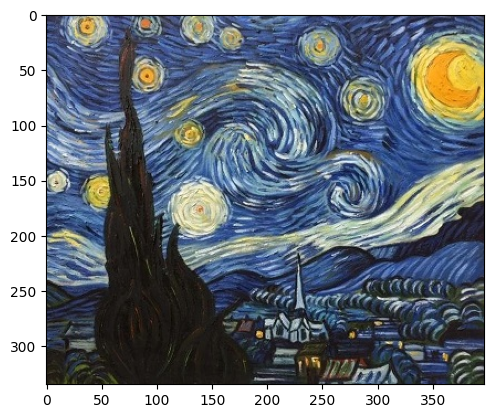

In [5]:
fname = '/kaggle/input/w1d4-data/w1d4_vangogh.jpg'
img = Image.open(fname)
print(f"Image size in pixels: {img.size[0]} x {img.size[1]} = {img.size[0] * img.size[1]}")
plt.imshow(img)

In [6]:
class TensorDataset:
    def __init__(self, *tensors: t.Tensor):
        """Validate the sizes and store the tensors in a field named `tensors`."""
        self.tensors = tensors
    
    def __getitem__(self, index: Union[int, slice]) -> tuple[t.Tensor, ...]:
        """Return a tuple of length len(self.tensors) with the index applied to each."""
        return tuple(data[index] for data in self.tensors)
    
    def __len__(self):
        """Return the size in the first dimension, common to all the tensors."""
        return self.tensors[0].shape[0]
    
    
test_tensor_dataset(TensorDataset)

Testing with index: 0
Testing with index: slice(0, 5, 1)
Testing with index: slice(1, 5, 2)
__main__.test_tensor_dataset passed in 0.06s.


In [7]:
def all_coordinates_scaled(height: int, width: int) -> t.Tensor:
    """Return a tensor of shape (height*width, 2) where each row is a (x, y) coordinate.

    The range of x and y should be from [-1, 1] in both height and width dimensions.
    """
    
    xs_repeated = repeat(t.arange(width, dtype = t.float32), 'w -> (h w)', h = height) / width
    ys_repeated = repeat(t.arange(height, dtype = t.float32), 'h -> (h w)', w = width) / height
    return t.stack((xs_repeated, ys_repeated), dim = 1) * 2.0 - 1.0


def preprocess_image(img: Image.Image) -> TensorDataset:
    """Convert an image into a supervised learning problem predicting (R, G, B) given (x, y).

    Return: TensorDataset wrapping input and label tensors.
    input: shape (num_pixels, 2)
    label: shape (num_pixels, 3)
    """
    img = transforms.ToTensor()(img)[:3, :, :]
    c, h, w = img.shape
    img_data = all_coordinates_scaled(h, w)
    img_labels = rearrange(img, 'c h w -> (h w) c') * 2.0 - 1.0
    return TensorDataset(img_data, img_labels)

In [8]:
def train_test_split(all_data: TensorDataset, train_frac=0.8, val_frac=0.01, test_frac=0.01) -> list[TensorDataset]:
    """Return [train, val, test] datasets containing the specified fraction of examples.

    If the fractions add up to less than 1, some of the data is not used.
    """
    n = len(all_data)
    indexes = t.randperm(n)
    train_bound = int(n * train_frac)
    valid_bound = int(n * val_frac) + train_bound
    test_bound = int(n * test_frac) + valid_bound
    train_dataset = TensorDataset(*all_data[indexes[:train_bound]])
    valid_dataset = TensorDataset(*all_data[indexes[train_bound:valid_bound]])
    test_dataset = TensorDataset(*all_data[indexes[valid_bound:test_bound]])
    return [train_dataset, valid_dataset, test_dataset]
    

all_data = preprocess_image(img)
(train_data, val_data, test_data) = train_test_split(all_data)
print(f"Dataset sizes: train {len(train_data)}, val {len(val_data)} test {len(test_data)}")

Dataset sizes: train 106396, val 1329 test 1329


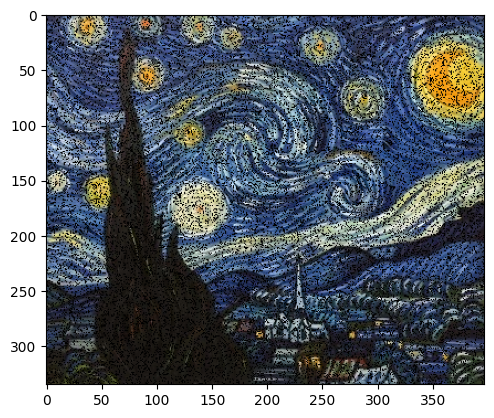

In [9]:
def to_grid(X: t.Tensor, Y: t.Tensor, width: int, height: int) -> t.Tensor:
    """Convert preprocessed data from the format used in the Dataset back to an image tensor.

    X: shape (n_pixels, dim=2)
    Y: shape (n_pixels, channel=3)

    Return: shape (height, width, channels=3)
    """
    n_pixels, dim = X.shape
    _, channels = Y.shape
    X = ((X + 1.0) / 2.0 * t.tensor([width, height]) + 0.5).long()
    Y = (Y + 1.0) / 2.0
    grid = t.zeros((height, width, 3))
    grid[X[:, 1], X[:, 0]] = Y
    return grid


(width, height) = img.size
(X, Y) = train_data.tensors
plt.figure()
plt.imshow(to_grid(X, Y, width, height))

In [10]:
train_loader = DataLoader(train_data, batch_size = 256, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 256)
test_loader = DataLoader(test_data, batch_size = 256)

In [11]:
def train_one_epoch(model: ImageMemorizer, dataloader: DataLoader) -> float:
    """Show each example in the dataloader to the model once.

    Use `torch.optim.Adam` for the optimizer (you'll build your own Adam optimizer later today).
    Use `F.l1_loss(prediction, actual)` for the loss function. This just puts less weight on very bright or dark pixels, which seems to produce nicer images.

    Return: the average loss per example seen, i.e. sum of losses of each batch weighted by the size of the batch, divided by the total number of examples seen
    """
    model.to(device)
    model.train()
    optimizer = t.optim.Adam(model.parameters())
    total_loss = 0.0
    n_elems = 0
    for x, y in tqdm(dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = F.l1_loss(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(x)
        n_elems += len(x)
    return total_loss / n_elems
    


In [12]:
def evaluate(model: ImageMemorizer, dataloader: DataLoader) -> float:
    """Return the total L1 loss over the provided data divided by the number of examples."""
    
    total_loss = 0.0
    n_elems = 0
    model.to(device)
    model.eval()
    with t.inference_mode():
        for x, y in tqdm(dataloader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = F.l1_loss(pred, y)
            total_loss += loss.item() * len(x)
            n_elems += len(x)
        return total_loss / n_elems
            

In [13]:
model = ImageMemorizer(2, 400, 3)

In [14]:
train_loss_history = []
val_loss_history = []
n_epochs = 50
for epoch in tqdm(range(n_epochs)):
    train_epoch_loss = train_one_epoch(model, train_loader)
    val_epoch_loss = evaluate(model, val_loader)
    train_loss_history.append(train_epoch_loss)
    val_loss_history.append(val_epoch_loss)
    
'''
fig, axes = plt.subplots(1, 2, figsize = (22, 8))
axes[0, 0].plot(range(n_epochs), train_loss_history)
axes[0, 1].plot(range(n_epochs), val_loss_history)
axes[0, 0].set_title('train loss history')
axes[0, 0].set_xlabel('epochs')
axes[0, 0].set_ylabel('train loss')
axes[0, 0].set_title('val loss history')
axes[0, 0].set_xlabel('epochs')
axes[0, 0].set_ylabel('val loss')
plt.show()
'''

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/416 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

"\nfig, axes = plt.subplots(1, 2, figsize = (22, 8))\naxes[0, 0].plot(range(n_epochs), train_loss_history)\naxes[0, 1].plot(range(n_epochs), val_loss_history)\naxes[0, 0].set_title('train loss history')\naxes[0, 0].set_xlabel('epochs')\naxes[0, 0].set_ylabel('train loss')\naxes[0, 0].set_title('val loss history')\naxes[0, 0].set_xlabel('epochs')\naxes[0, 0].set_ylabel('val loss')\nplt.show()\n"

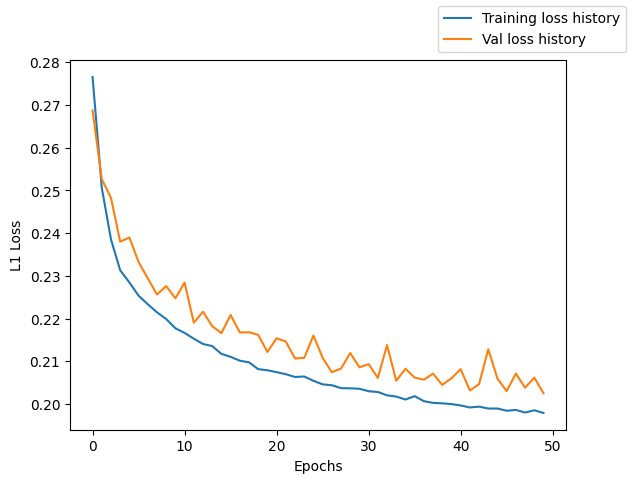

In [15]:
fig, ax = plt.subplots()
ax.plot(train_loss_history, label = 'Training loss history')
ax.plot(val_loss_history, label = 'Val loss history')
ax.set(xlabel="Epochs", ylabel="L1 Loss")
fig.legend()

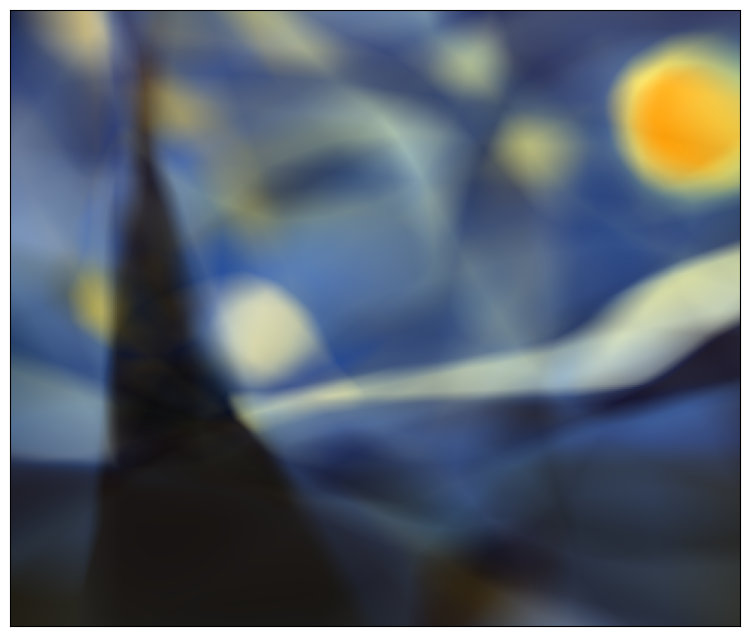

In [16]:
X = all_coordinates_scaled(height, width)
with t.inference_mode():
    pred = model(X.to(device)).cpu()
    
grid = to_grid(X, pred, width, height)
grid.clip_(0, 1)
fig, ax = plt.subplots(figsize = (22, 8))
ax.imshow(grid)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

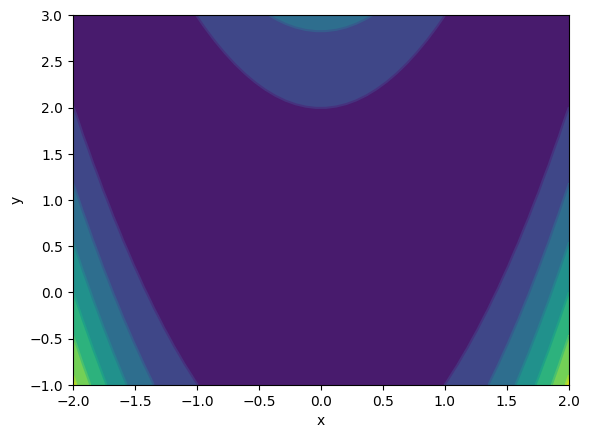

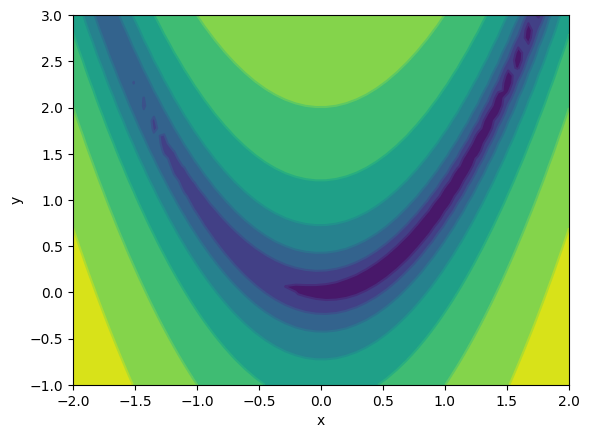

In [17]:
def rosenbrocks_banana(x: t.Tensor, y: t.Tensor, a=1, b=100) -> t.Tensor:
    return (a - x) ** 2 + b * (y - x**2) ** 2 + 1


def plot_rosenbrock(xmin=-2, xmax=2, ymin=-1, ymax=3, n_points=50, log_scale=False) -> matplotlib.figure.Figure:
    """Plot the rosenbrocks_banana function over the specified domain.

    If log_scale is True, take the logarithm of the output before plotting.
    """
    fig, ax = plt.subplots()
    x = t.linspace(xmin, xmax, n_points)
    y = t.linspace(ymin, ymax, n_points)
    xx = repeat(x, "x -> y x", y=n_points)
    yy = repeat(y, "y -> y x", x=n_points)
    zs = rosenbrocks_banana(xx, yy)
    contour = ax.contourf(x, y, t.log(zs) if log_scale else zs)
    ax.contour(contour)
    ax.set(xlabel="x", ylabel="y")
    return fig

plot_rosenbrock()
fig = plot_rosenbrock(log_scale = True)

  0%|          | 0/100 [00:00<?, ?it/s]

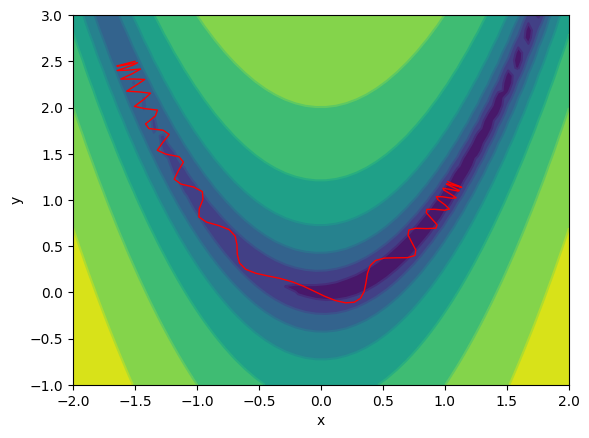

In [18]:
def opt_banana(xy: t.Tensor, n_iters: int, lr=0.001, momentum=0.98):
    """Optimize the banana starting from the specified point.

    xy: shape (2,). The (x, y) starting point.
    n_iters: number of steps.

    Return: (n_iters, 2). The (x,y) BEFORE each step. So out[0] is the starting point.
    """
    assert xy.requires_grad
    optimizer = t.optim.SGD([xy], lr = lr, momentum = momentum)
    out = xy.new_zeros((n_iters, 2))
    
    for i in tqdm(range(n_iters)):
        out[i] = xy.detach()
        optimizer.zero_grad()
        rosenbrocks_banana(xy[0], xy[1]).backward()
        optimizer.step()
    return out

xy = t.tensor([-1.5, 2.5], requires_grad=True)
xys = opt_banana(xy, n_iters=100, lr = 0.001).numpy()
fig = plot_rosenbrock(log_scale=True)
fig.axes[0].plot(xys[:, 0], xys[:, 1], color="r", linewidth=1)

In [34]:
class SGD:
    def __init__(self, params: Iterable[t.nn.parameter.Parameter], lr: float, momentum: float, weight_decay: float):
        """Implements SGD with momentum.

        Like the PyTorch version, but assume nesterov=False, maximize=False, and dampening=0
            https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

        """
        self.lr = lr
        self.params = list(params)
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.b = [None for _ in self.params]

    def zero_grad(self) -> None:
        for param in self.params:
            param.grad = None

    @t.inference_mode()
    def step(self) -> None:
        for i, p in enumerate(self.params):
            grad = p.grad
            if self.weight_decay != 0:
                grad = grad + self.weight_decay * p
                
            if self.momentum != 0:
                b = self.b[i]
                if b is not None:
                    self.b[i] = self.momentum * b + grad
                else:
                    self.b[i] = grad
                grad = self.b[i]
            self.params[i] -= self.lr * grad
                
                
test_sgd(SGD)


Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'weight_decay': 0.0}

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'weight_decay': 0.0}

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'weight_decay': 0.0}

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'weight_decay': 0.05}

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'weight_decay': 0.05}
__main__.test_sgd passed in 0.14s.


In [42]:
class RMSprop:
    def __init__(
        self,
        params: Iterable[t.nn.parameter.Parameter],
        lr: float,
        alpha: float,
        eps: float,
        weight_decay: float,
        momentum: float,
    ):
        """Implements RMSprop.

        Like the PyTorch version, but assumes centered=False
            https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop

        """
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.v = [t.zeros_like(p) for p in self.params]
        self.b = [t.zeros_like(p) for p in self.params]
        self.g_ave = [t.zeros_like(p) for p in self.params]

    def zero_grad(self) -> None:
        for p in self.params:
            p.grad = None

    @t.inference_mode()
    def step(self) -> None:
        
        for i, p in enumerate(self.params):
            g = p.grad
            if self.weight_decay != 0:
                g = g + self.weight_decay * p
            self.v[i] = self.alpha * self.v[i] + (1.0 - self.alpha) * g ** 2
            if self.momentum > 0:
                self.b[i] = self.momentum * self.b[i] + g / (self.v[i] ** 0.5 + self.eps)
                p -=  self.lr * self.b[i]
            else:
                p -= self.lr * g / (self.v[i] ** 0.5 + self.eps)
                
test_rmsprop(RMSprop)
                


Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
__main__.test_rmsprop passed in 0.13s.


In [49]:


class Adam:
    def __init__(
        self,
        params: Iterable[t.nn.parameter.Parameter],
        lr: float = 0.001,
        betas: tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-08,
        weight_decay: float = 0.0,
    ):
        """Implements Adam.

        Like the PyTorch version, but assumes amsgrad=False and maximize=False
            https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
        """
        self.params = list(params)
        self.lr = lr
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.eps = eps
        self.weight_decay = weight_decay
        self.m = [t.zeros_like(p) for p in self.params]
        self.v = [t.zeros_like(p) for p in self.params]
        self.t = 0

    def zero_grad(self) -> None:
        for p in self.params:
            p.grad = None

    @t.inference_mode()
    def step(self) -> None:
        
        self.t += 1
        for i, p in enumerate(self.params):
            g = p.grad
            if self.weight_decay != 0:
                g = g + self.weight_decay * p
            
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * g ** 2
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            p -= self.lr * m_hat / (v_hat ** 0.5 + self.eps)
        
        
test_adam(Adam)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
__main__.test_adam passed in 0.11s.
